In [1]:
import pyarrow.feather as feather
import numpy as np
import pandas as pd
import os
from tensorflow import keras
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set()
from collections import Counter

from sklearn.preprocessing import StandardScaler
from tqdm import tqdm,trange 
from pandas.tseries.offsets import Day, YearEnd, YearBegin
from datetime import datetime, timedelta

from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout
from keras import regularizers
from keras.callbacks import EarlyStopping
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV,PredefinedSplit
from keras.wrappers.scikit_learn import KerasRegressor, KerasClassifier
from sklearn.metrics import mean_squared_error, make_scorer, accuracy_score, f1_score, classification_report
from scipy.stats import reciprocal, uniform
import heapq
import yfinance as yf


In [2]:
pd.options.display.max_columns = 10 # 最大显示列数
pd.options.display.max_rows = 10 # 最大显示行数

## read character data

In [3]:
directory_path = os.getcwd()
folder_name = os.path.basename(directory_path)
directory_path = os.getcwd()

In [4]:
# raw_df=feather.read_feather('/Users/shuxianhong/Desktop/Summer Project/chars60_raw_imputed.feather')
raw_df = pd.read_feather(os.path.join(directory_path, 'chars60_raw_imputed.feather'))

In [5]:
raw_df.columns

Index(['gvkey', 'permno', 'sic', 'ret', 'exchcd', 'shrcd', 'adm', 'bm_ia',
       'herf', 'hire', 'me_ia', 'baspread', 'beta', 'ill', 'maxret', 'mom12m',
       'mom1m', 'mom36m', 'mom60m', 'mom6m', 're', 'rvar_capm', 'rvar_ff3',
       'rvar_mean', 'seas1a', 'std_dolvol', 'std_turn', 'zerotrade', 'me',
       'dy', 'turn', 'dolvol', 'abr', 'sue', 'cinvest', 'nincr', 'pscore',
       'acc', 'bm', 'agr', 'alm', 'ato', 'cash', 'cashdebt', 'cfp', 'chcsho',
       'chpm', 'chtx', 'depr', 'ep', 'gma', 'grltnoa', 'lev', 'lgr', 'ni',
       'noa', 'op', 'pctacc', 'pm', 'rd_sale', 'rdm', 'rna', 'roa', 'roe',
       'rsup', 'sgr', 'sp', 'date', 'ffi49'],
      dtype='object')

In [6]:
raw_tf = raw_df.isnull().any()
raw_tf.where(raw_tf == True).dropna().index.to_list()

['adm',
 'bm_ia',
 'mom12m',
 'mom36m',
 'mom60m',
 'mom6m',
 'seas1a',
 'abr',
 'sue',
 'cinvest',
 'nincr',
 'pscore',
 'acc',
 'bm',
 'agr',
 'alm',
 'ato',
 'cashdebt',
 'chcsho',
 'chpm',
 'chtx',
 'gma',
 'grltnoa',
 'lgr',
 'ni',
 'noa',
 'op',
 'pctacc',
 'rna',
 'roa',
 'roe',
 'rsup',
 'sgr']

In [7]:
raw_df['year'] = raw_df['date'].dt.year
raw_df = raw_df[raw_df['year'] >= 1972]
raw_df = raw_df.drop(['year'], axis=1)

In [8]:
raw_tf = raw_df.isnull().any()
raw_tf.where(raw_tf == True).dropna().index.to_list()

[]

no missing value!

In [9]:
raw_df

,gvkey,permno,sic,ret,exchcd,...,rsup,sgr,sp,date,ffi49
136,1010,10006,3743,0.004854,1.0,...,0.000047,0.042217,0.001158,1972-01-31,25
137,1010,10006,3743,-0.007729,1.0,...,0.000047,0.042217,0.001152,1972-02-29,25
138,1010,10006,3743,-0.068966,1.0,...,0.000048,0.042217,0.001175,1972-03-31,25
139,1010,10006,3743,-0.068783,1.0,...,0.000051,0.042217,0.001262,1972-04-30,25
140,1010,10006,3743,0.025000,1.0,...,-0.000004,-0.003038,0.001351,1972-05-31,25
...,...,...,...,...,...,...,...,...,...,...,...
551140,260778,90272,6324,-0.057476,1.0,...,0.000146,0.272945,0.001559,2019-08-31,46
551141,260778,90272,6324,-0.042735,1.0,...,0.000155,0.272945,0.001654,2019-09-30,46
551142,260778,90272,6324,0.144423,1.0,...,0.000162,0.272945,0.001728,2019-10-31,46
551143,260778,90272,6324,0.085873,1.0,...,0.000159,0.380853,0.001668,2019-11-30,46


## read macro data

In [10]:
# macro_df = pd.read_csv('/Users/shuxianhong/Desktop/Summer Project/Macro.csv')

macro_df = pd.read_csv(os.path.join(directory_path,'Macro.csv'))
macro_df = macro_df[macro_df['yyyymm']>=197201]

In [11]:
macro_df

,yyyymm,b/m,tbl,ntis,svar,d/p,e/p,dfy,tms
1212,197201,0.635357,0.0338,0.033075,0.000494,1.529644,1.258123,0.0104,0.0268
1213,197202,0.617586,0.0320,0.033030,0.000284,1.540497,1.266209,0.0096,0.0282
1214,197203,0.645902,0.0373,0.031723,0.000545,1.543056,1.266019,0.0100,0.0240
1215,197204,0.636784,0.0371,0.032492,0.000383,1.544956,1.263950,0.0094,0.0244
1216,197205,0.632442,0.0369,0.030657,0.000769,1.552395,1.267456,0.0093,0.0228
...,...,...,...,...,...,...,...,...,...
1795,202008,0.235975,0.0010,-0.008504,0.000743,1.772309,1.550421,0.0102,0.0055
1796,202009,0.241482,0.0011,-0.005698,0.004907,1.756971,1.534527,0.0105,0.0057
1797,202010,0.253146,0.0010,-0.001895,0.003661,1.746197,1.528413,0.0109,0.0069
1798,202011,0.226352,0.0009,-0.005262,0.002492,1.791974,1.578931,0.0100,0.0078


## merge macro & char

In [12]:
raw_df['yyyymm'] = raw_df['date'].dt.strftime('%Y%m').apply(int)
total_df = pd.merge(raw_df, macro_df, how='inner',on='yyyymm')
total_df.drop(columns='yyyymm',inplace=True)
total_df

,gvkey,permno,sic,ret,exchcd,...,svar,d/p,e/p,dfy,tms
0,1010,10006,3743,0.004854,1.0,...,0.000494,1.529644,1.258123,0.0104,0.0268
1,1040,15763,3949,0.111399,1.0,...,0.000494,1.529644,1.258123,0.0104,0.0268
2,1043,18980,5040,0.080000,1.0,...,0.000494,1.529644,1.258123,0.0104,0.0268
3,1045,21020,4512,0.042945,1.0,...,0.000494,1.529644,1.258123,0.0104,0.0268
4,1070,21549,3714,0.191489,2.0,...,0.000494,1.529644,1.258123,0.0104,0.0268
...,...,...,...,...,...,...,...,...,...,...,...
462751,188255,12981,2430,0.048165,1.0,...,0.000746,1.722817,1.265919,0.0076,0.0371
462752,189491,13035,3561,0.001157,1.0,...,0.000746,1.722817,1.265919,0.0076,0.0371
462753,199356,13168,7370,-0.062160,3.0,...,0.000746,1.722817,1.265919,0.0076,0.0371
462754,260774,90199,6500,0.084983,1.0,...,0.000746,1.722817,1.265919,0.0076,0.0371


In [13]:
raw_tf = total_df.isnull().any()
raw_tf.where(raw_tf == True).dropna().index.to_list()

[]

In [14]:
total_df.shrcd.nunique()

2

## information variable

- stock indicator: gvkey, permno
- time: datadate, date, year ('datadate' is the available time for data and 'date' is the date of return)
- industry: sic, ffi49
- exchange info: exchcd (exchange code), shrcd (share code, eg: 1=ordinary common share)
- return: ret: the dividend adjusted return (we also provide original return and return without dividend, you can keep them by modifing impute_rank_output_bchmk.py)
- market equity: me/rank_me


In [15]:
# need to turn some variables to dummy variables
def get_dummy_col(target_df, col_names):
    """turn the cols into multiple cols containing dummy variables, then drop the original columns

    Args:
        target_df (pandas dataframe): target dataframe
        col_names (list): list of columns that need to be turned into dummy variables
    """
    for col in col_names:        
        tmp_dummies = pd.get_dummies(target_df[col]).rename(columns=lambda x: f'{col}_' + str(x))
        target_df = pd.concat([target_df, tmp_dummies], axis=1)
        target_df.drop(col, inplace=True, axis = 1)
    return target_df 
dummy_col_list = ['ffi49'] # do we really need shrcd & exchcd? drop these two and only consider ffi49 as dummy
total_df = get_dummy_col(total_df, dummy_col_list)

In [16]:
total_df.set_index('date', inplace=True)
total_df.sort_values(by=['permno','date'])
total_df

,gvkey,permno,sic,ret,exchcd,...,ffi49_45,ffi49_46,ffi49_47,ffi49_48,ffi49_49
date,,,,,,,,,,,
1972-01-31,1010,10006,3743,0.004854,1.0,...,0,0,0,0,0
1972-01-31,1040,15763,3949,0.111399,1.0,...,0,0,0,0,0
1972-01-31,1043,18980,5040,0.080000,1.0,...,0,0,0,0,0
1972-01-31,1045,21020,4512,0.042945,1.0,...,0,0,0,0,0
1972-01-31,1070,21549,3714,0.191489,2.0,...,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
2013-12-31,188255,12981,2430,0.048165,1.0,...,0,0,0,0,0
2013-12-31,189491,13035,3561,0.001157,1.0,...,0,0,0,0,0
2013-12-31,199356,13168,7370,-0.062160,3.0,...,0,0,0,0,0


In [17]:
total_df.columns

Index(['gvkey', 'permno', 'sic', 'ret', 'exchcd', 'shrcd', 'adm', 'bm_ia',
       'herf', 'hire',
       ...
       'ffi49_40', 'ffi49_41', 'ffi49_42', 'ffi49_43', 'ffi49_44', 'ffi49_45',
       'ffi49_46', 'ffi49_47', 'ffi49_48', 'ffi49_49'],
      dtype='object', length=123)

<AxesSubplot:xlabel='date'>

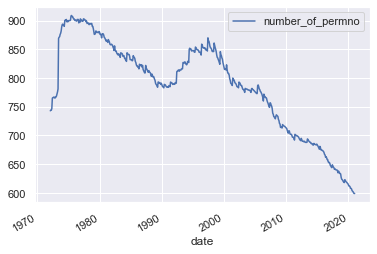

In [18]:
each_month_permno_num = pd.DataFrame(Counter(total_df.reset_index().date).items(), columns=['date', 'number_of_permno'])
each_month_permno_num.plot(x='date', y='number_of_permno')

In [19]:
# set character features list
features_list = total_df.columns.tolist()
remove_list = {'gvkey', 'permno', 'ret','sic','exchcd','shrcd'}
features_list = [ele for ele in features_list if ele not in remove_list]
len(features_list)

117

In [20]:
print(features_list)

['adm', 'bm_ia', 'herf', 'hire', 'me_ia', 'baspread', 'beta', 'ill', 'maxret', 'mom12m', 'mom1m', 'mom36m', 'mom60m', 'mom6m', 're', 'rvar_capm', 'rvar_ff3', 'rvar_mean', 'seas1a', 'std_dolvol', 'std_turn', 'zerotrade', 'me', 'dy', 'turn', 'dolvol', 'abr', 'sue', 'cinvest', 'nincr', 'pscore', 'acc', 'bm', 'agr', 'alm', 'ato', 'cash', 'cashdebt', 'cfp', 'chcsho', 'chpm', 'chtx', 'depr', 'ep', 'gma', 'grltnoa', 'lev', 'lgr', 'ni', 'noa', 'op', 'pctacc', 'pm', 'rd_sale', 'rdm', 'rna', 'roa', 'roe', 'rsup', 'sgr', 'sp', 'b/m', 'tbl', 'ntis', 'svar', 'd/p', 'e/p', 'dfy', 'tms', 'ffi49_1', 'ffi49_2', 'ffi49_3', 'ffi49_4', 'ffi49_5', 'ffi49_6', 'ffi49_7', 'ffi49_8', 'ffi49_9', 'ffi49_10', 'ffi49_11', 'ffi49_12', 'ffi49_13', 'ffi49_14', 'ffi49_15', 'ffi49_16', 'ffi49_17', 'ffi49_18', 'ffi49_19', 'ffi49_21', 'ffi49_22', 'ffi49_23', 'ffi49_24', 'ffi49_25', 'ffi49_26', 'ffi49_27', 'ffi49_28', 'ffi49_29', 'ffi49_30', 'ffi49_31', 'ffi49_32', 'ffi49_33', 'ffi49_34', 'ffi49_35', 'ffi49_36', 'ffi49_37

## check distribution and correlation 

C:\Users\haosh\AppData\Local\Temp\ipykernel_12676\3608439455.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  total_df[features_list[:69]].hist(layout=(28, 6), bins=np.linspace(-1,1,50), ax=ax);


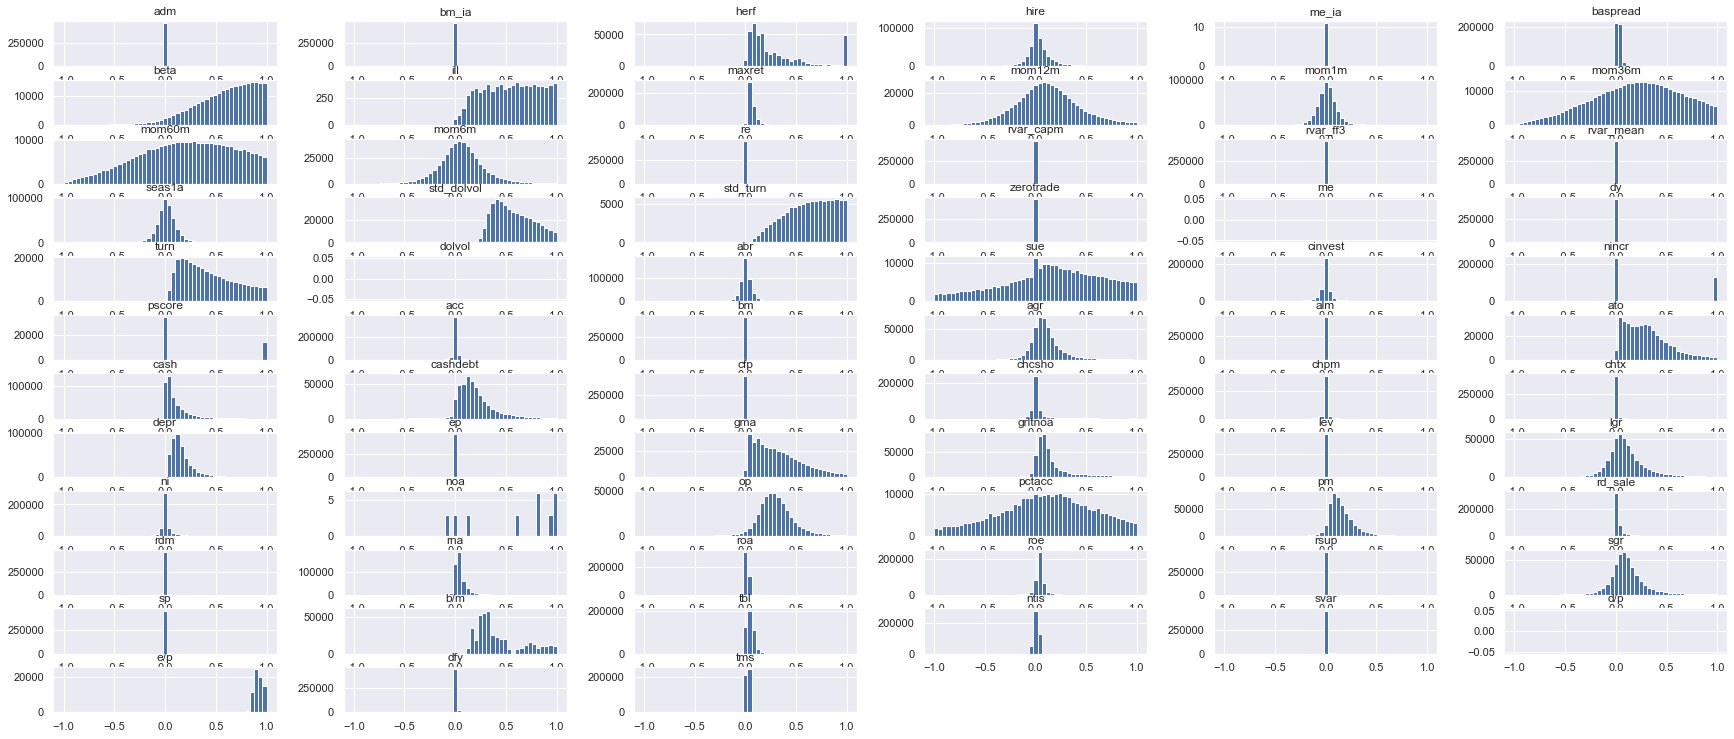

In [25]:
fig, ax = plt.subplots()
fig.set_figheight(30)
fig.set_figwidth(30)
total_df[features_list[:69]].hist(layout=(28, 6), bins=np.linspace(-1,1,50), ax=ax);

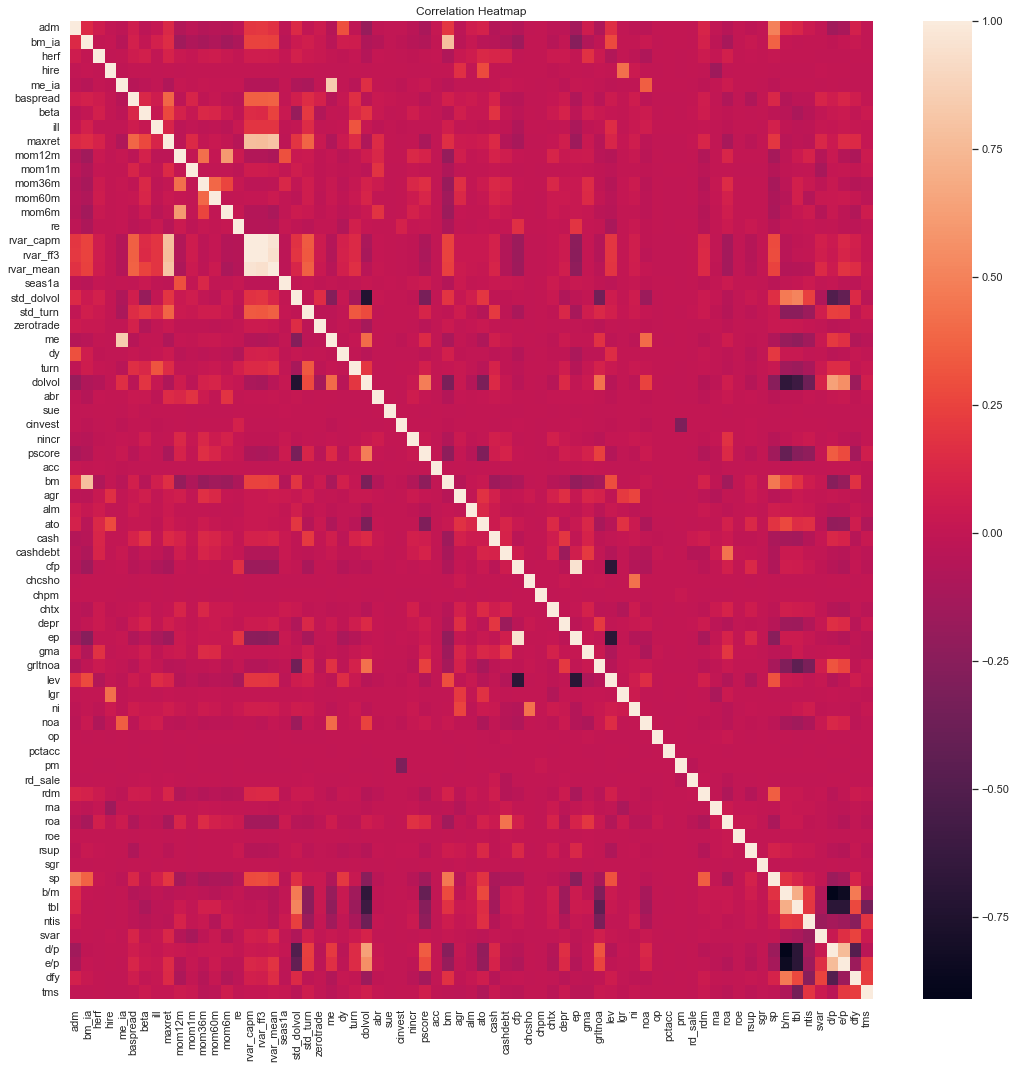

<Figure size 432x288 with 0 Axes>

In [26]:
plt.figure(figsize = (18,18))
sns.heatmap(data=total_df[features_list[:69]].corr())
plt.title('Correlation Heatmap')
plt.show()
plt.gcf().clear()

In [20]:
table_for_interaction = total_df[features_list[:69]]
single_features = features_list[:61]
macro_features = features_list[61:69]

interaction_table = pd.DataFrame(data = None, index = table_for_interaction.index)
for i in single_features:
    for j in macro_features:
        interaction_table[i + '+' + j] = table_for_interaction[i] * table_for_interaction[j]

/var/folders/wt/38bxwst538g75np4smkby7mm0000gn/T/ipykernel_15798/3943038917.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  interaction_table[i + '+' + j] = table_for_interaction[i] * table_for_interaction[j]
/var/folders/wt/38bxwst538g75np4smkby7mm0000gn/T/ipykernel_15798/3943038917.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  interaction_table[i + '+' + j] = table_for_interaction[i] * table_for_interaction[j]
/var/folders/wt/38bxwst538g75np4smkby7mm0000gn/T/ipykernel_15798/3943038917.py:8: PerformanceWarning: DataFr

In [21]:
interaction_table

,adm+b/m,adm+tbl,adm+ntis,adm+svar,adm+d/p,...,sp+svar,sp+d/p,sp+e/p,sp+dfy,sp+tms
date,,,,,,,,,,,
1972-01-31,3.791261e-06,2.016892e-07,1.973637e-07,2.949077e-09,0.000009,...,5.721860e-07,0.001771,0.001457,1.204066e-05,0.000031
1972-01-31,2.352534e-05,1.251511e-06,1.224671e-06,1.829946e-08,0.000057,...,3.621837e-07,0.001121,0.000922,7.621528e-06,0.000020
1972-01-31,2.352534e-05,1.251511e-06,1.224671e-06,1.829946e-08,0.000057,...,7.375680e-07,0.002283,0.001878,1.552084e-05,0.000040
1972-01-31,1.961296e-05,1.043379e-06,1.021002e-06,1.525617e-08,0.000047,...,5.659505e-07,0.001752,0.001441,1.190945e-05,0.000031
1972-01-31,2.352534e-05,1.251511e-06,1.224671e-06,1.829946e-08,0.000057,...,3.358631e-06,0.010395,0.008550,7.067657e-05,0.000182
...,...,...,...,...,...,...,...,...,...,...,...
2013-12-31,7.535672e-06,1.732861e-08,3.006245e-07,1.845586e-08,0.000043,...,3.765140e-07,0.000870,0.000639,3.838187e-06,0.000019
2013-12-31,8.049202e-07,1.850950e-09,3.211110e-08,1.971357e-09,0.000005,...,4.372021e-07,0.001010,0.000742,4.456841e-06,0.000022
2013-12-31,4.666211e-06,1.073016e-08,1.861516e-07,1.142817e-08,0.000026,...,5.609332e-08,0.000130,0.000095,5.718157e-07,0.000003


In [22]:
new_total_df = pd.concat([total_df, interaction_table], axis=1)

In [24]:
new_total_df    

,gvkey,permno,sic,ret,exchcd,...,sp+svar,sp+d/p,sp+e/p,sp+dfy,sp+tms
date,,,,,,,,,,,
1972-01-31,1010,10006,3743,0.004854,1.0,...,5.721860e-07,0.001771,0.001457,1.204066e-05,0.000031
1972-01-31,1040,15763,3949,0.111399,1.0,...,3.621837e-07,0.001121,0.000922,7.621528e-06,0.000020
1972-01-31,1043,18980,5040,0.080000,1.0,...,7.375680e-07,0.002283,0.001878,1.552084e-05,0.000040
1972-01-31,1045,21020,4512,0.042945,1.0,...,5.659505e-07,0.001752,0.001441,1.190945e-05,0.000031
1972-01-31,1070,21549,3714,0.191489,2.0,...,3.358631e-06,0.010395,0.008550,7.067657e-05,0.000182
...,...,...,...,...,...,...,...,...,...,...,...
2013-12-31,188255,12981,2430,0.048165,1.0,...,3.765140e-07,0.000870,0.000639,3.838187e-06,0.000019
2013-12-31,189491,13035,3561,0.001157,1.0,...,4.372021e-07,0.001010,0.000742,4.456841e-06,0.000022
2013-12-31,199356,13168,7370,-0.062160,3.0,...,5.609332e-08,0.000130,0.000095,5.718157e-07,0.000003


In [23]:
new_features_list = new_total_df.columns
remove_list = {'gvkey', 'permno', 'ret','sic','exchcd','shrcd','b/m', 'tbl', 'ntis', 'svar', 'd/p', 'e/p', 'dfy', 'tms'}
new_features_list = [ele for ele in new_features_list if ele not in remove_list]
len(new_features_list)

597

## normalization 

In [24]:
scaler = StandardScaler()
scaler.fit(new_total_df[new_features_list])
normalized = scaler.transform(new_total_df[new_features_list])
normalized_data = pd.DataFrame(normalized , columns=new_features_list, index=new_total_df.index)

print("The shape of normalised numerical data : " , normalized.shape)
normalized_data

The shape of normalised numerical data :  (462756, 597)


,adm,bm_ia,herf,hire,me_ia,...,sp+svar,sp+d/p,sp+e/p,sp+dfy,sp+tms
date,,,,,,,,,,,
1972-01-31,-0.266273,0.060930,1.331469,-0.018029,0.006061,...,-0.127708,-0.166431,-0.142307,-0.173324,-0.086121
1972-01-31,0.014889,-0.276326,-0.500789,-0.010624,0.019947,...,-0.133609,-0.251600,-0.225614,-0.235525,-0.167071
1972-01-31,0.014889,0.113205,2.258603,-0.021854,0.000136,...,-0.123061,-0.099358,-0.076700,-0.124338,-0.022371
1972-01-31,-0.040853,-0.850659,-0.833250,-0.016621,0.021434,...,-0.127884,-0.168960,-0.144780,-0.175170,-0.088525
1972-01-31,0.014889,1.557838,-0.219789,-0.013646,-0.094976,...,-0.049411,0.963650,0.963070,0.652008,0.987978
...,...,...,...,...,...,...,...,...,...,...,...
2013-12-31,-0.096199,0.068467,-0.173786,-0.013646,0.071497,...,-0.133207,-0.284480,-0.269665,-0.288778,-0.173495
2013-12-31,-0.296352,-0.052338,-0.518638,-0.012219,-0.253867,...,-0.131501,-0.266103,-0.253607,-0.280070,-0.152028
2013-12-31,-0.181529,-0.294847,-0.156035,0.009551,-3.528136,...,-0.142210,-0.381504,-0.354449,-0.334754,-0.286841


In [25]:
normalized_data.describe()

,adm,bm_ia,herf,hire,me_ia,...,sp+svar,sp+d/p,sp+e/p,sp+dfy,sp+tms
count,4.627560e+05,4.627560e+05,4.627560e+05,4.627560e+05,4.627560e+05,...,4.627560e+05,4.627560e+05,4.627560e+05,4.627560e+05,4.627560e+05
mean,2.841376e-15,-2.038921e-17,-2.332824e-15,-2.232020e-15,1.067552e-17,...,6.260836e-17,2.047360e-15,-1.827087e-16,-3.685600e-16,1.395350e-15
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,...,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-3.202886e-01,-1.567056e+01,-1.039444e+00,-1.028637e-01,-2.200163e+01,...,-2.496548e+01,-8.733977e+00,-1.433198e+01,-1.817117e+01,-1.060556e+01
25%,-2.661362e-01,-2.693524e-01,-7.353735e-01,-1.577029e-02,-1.183916e-01,...,-1.274734e-01,-2.921559e-01,-2.711765e-01,-2.797184e-01,-2.564211e-01
50%,-1.820625e-01,-4.781521e-02,-4.402527e-01,-1.191368e-02,-1.113683e-02,...,-1.026092e-01,-1.889196e-01,-1.754387e-01,-2.010753e-01,-1.720464e-01
75%,7.905231e-03,1.431363e-01,4.222584e-01,-5.272497e-03,1.320859e-02,...,-3.992463e-02,1.621282e-02,1.208928e-02,-1.028332e-02,9.947542e-03
max,1.844458e+02,1.688836e+02,2.258603e+00,1.894846e+02,6.208946e+01,...,2.994299e+02,2.046039e+02,2.178407e+02,2.322488e+02,2.420584e+02


## Split data

In [26]:
X_total = normalized_data
Y_total = pd.DataFrame(new_total_df['ret'], index=new_total_df.index)
permno_list = new_total_df['permno']

- rolling 4 times
- total:1972-2020 49 years
- training_length: 32 years // 20 // 14
- valid_length: 7 years // 10 // 6
- testing_length: 7 years // 16 // 26

In [30]:
X_total.columns[:61]

Index(['adm', 'bm_ia', 'herf', 'hire', 'me_ia', 'baspread', 'beta', 'ill',
       'maxret', 'mom12m', 'mom1m', 'mom36m', 'mom60m', 'mom6m', 're',
       'rvar_capm', 'rvar_ff3', 'rvar_mean', 'seas1a', 'std_dolvol',
       'std_turn', 'zerotrade', 'me', 'dy', 'turn', 'dolvol', 'abr', 'sue',
       'cinvest', 'nincr', 'pscore', 'acc', 'bm', 'agr', 'alm', 'ato', 'cash',
       'cashdebt', 'cfp', 'chcsho', 'chpm', 'chtx', 'depr', 'ep', 'gma',
       'grltnoa', 'lev', 'lgr', 'ni', 'noa', 'op', 'pctacc', 'pm', 'rd_sale',
       'rdm', 'rna', 'roa', 'roe', 'rsup', 'sgr', 'sp'],
      dtype='object')

In [27]:
train_start_list = pd.date_range('19720101', '19750101', freq='AS-JAN')
train_start_list

DatetimeIndex(['1972-01-01', '1973-01-01', '1974-01-01', '1975-01-01'], dtype='datetime64[ns]', freq='AS-JAN')

In [28]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [29]:
def data_split(chardf, retdf, permno_list, start_date, train_period, valid_period, test_period):
    
    end_date = start_date + train_period * YearEnd()
    valid_date = end_date + valid_period * YearEnd() 
    test_date = valid_date + test_period * YearEnd()

    # training set
    train_x = chardf.loc[start_date.strftime('%Y%m%d'):end_date.strftime('%Y%m%d')]
    train_y = retdf.loc[start_date.strftime('%Y%m%d'):end_date.strftime('%Y%m%d')] 

    # validation set
    valid_x = chardf.loc[(end_date + timedelta(days=1)).strftime('%Y%m%d'):valid_date.strftime('%Y%m%d')]
    valid_y = retdf.loc[(end_date + timedelta(days=1)).strftime('%Y%m%d'):valid_date.strftime('%Y%m%d')]
            
    # testing set
    test_x = chardf.loc[(valid_date + timedelta(days=1)).strftime('%Y%m%d'):test_date.strftime('%Y%m%d')]
    test_y = retdf.loc[(valid_date + timedelta(days=1)).strftime('%Y%m%d'):test_date.strftime('%Y%m%d')]  
    test_permno = permno_list.loc[(valid_date + timedelta(days=1)).strftime('%Y%m%d'):test_date.strftime('%Y%m%d')]  
    
    return train_x, train_y, valid_x, valid_y, test_x, test_y, test_permno

In [126]:
# rolling1 = data_split(X_total, Y_total, permno_list, train_start_list[0], 14, 6, 26) # training start from'1972-01-01'
# rolling2 = data_split(X_total, Y_total,permno_list, train_start_list[1], 14, 6, 26) # training start from'1973-01-01'
# rolling3 = data_split(X_total, Y_total,permno_list, train_start_list[2], 14, 6, 26) # training start from'1974-01-01'
rolling4 = data_split(X_total, Y_total,permno_list, train_start_list[3], 14, 6, 26) # training start from'1975-01-01'

In [127]:
rolling4[6]

date
1995-01-31    50906
1995-01-31    21020
1995-01-31    27991
1995-01-31    20482
1995-01-31    10057
              ...  
2013-12-31    12981
2013-12-31    13035
2013-12-31    13168
2013-12-31    90199
2013-12-31    90272
Name: permno, Length: 230702, dtype: int64

## R2_oos

In [30]:
# R_square_oos
def r2_oos(true, pred):
    
    return 1-np.sum((pred-true)**2) / np.sum((true)**2)

## Neural Network

- Hyperparameters
  - L1 penalty λ1 ∈ (10−5, 10−3) 
  - Learning Rate LR ∈ {0.001, 0.01} 
  - Batch Size=10000 
  - Epochs=100 
  - Patience=5 
  - Adam Para.= Default 
  - Ensemble=10000

In [31]:
callback = [EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')]

### NN1

In [172]:
keras.backend.clear_session()

In [173]:
np.random.seed(42)
tf.random.set_seed(42)

In [174]:
def NN1(learning_rate=0.001, k_reg = 10e-5): 
    '''
    single hidden layer of 32 neurons
    '''
    model = Sequential()   
    model.add(Dense(32, activation='relu',kernel_regularizer=regularizers.l1(k_reg)))
    model.add(Dense(1, activation='relu'))
        
    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=opt, metrics=['mse'])
        
    return model

In [175]:
preddf_NN1 = pd.DataFrame() 
r2_OOS_NN1 = []

features = X_total.columns[:61]
rsquared_df = pd.DataFrame(columns=['NN1'], index=features)
rsquared_df['NN1'] = np.zeros((len(rsquared_df),1)).tolist()


for start_date in tqdm(train_start_list):
    data = data_split(X_total, Y_total, permno_list, start_date, 14, 6, 26)
    train_x = data[0]
    train_y = data[1]
    valid_x = data[2]
    valid_y = data[3]
    test_x = data[4]
    test_y = data[5]
    test_permno = data[6]
    
    temp_preddf = pd.DataFrame() 
    temp_preddf['permno'] = test_permno
    temp_preddf['real_y'] = test_y.iloc[:,0]
    
    regr_NN1 = KerasRegressor(NN1)
    regr_NN1.fit(train_x, train_y, epochs=50,
                 validation_data=(valid_x, valid_y), 
                 callbacks=callback, 
                 batch_size=1000)
    
    predict_yNN1 = regr_NN1.predict(test_x)
    temp_preddf[start_date] = predict_yNN1
    
    r2_OOS_NN1.append(r2_oos(temp_preddf['real_y'],temp_preddf[start_date]))
    
    if start_date == train_start_list[0]:
        preddf_NN1 = preddf_NN1.append(temp_preddf)
    else:
        preddf_NN1 = pd.merge(preddf_NN1, temp_preddf, on=['date', 'permno'], how='outer')
    
    for feature in features:
        new_test_x = test_x.copy(deep=True)
        col = new_test_x.filter(like=feature, axis=1).columns  
        #if feature = 'adm', change all columns those contain adm to 0  
        new_test_x[col] = 0
                
        new_pred_NN1 = regr_NN1.predict(new_test_x)
        new_rsq_1 = r2_oos(temp_preddf['real_y'],new_pred_NN1)
        rsquared_df.loc[feature, 'NN1'].append(new_rsq_1)

  0%|                                                     | 0/4 [00:00<?, ?it/s]/var/folders/wt/38bxwst538g75np4smkby7mm0000gn/T/ipykernel_9503/2682302704.py:23: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  regr_NN1 = KerasRegressor(NN1)


Epoch 1/50
145/145 [==============================] - 1s 5ms/step - loss: 0.0221 - mse: 0.3012 - val_loss: 2.5758e-04 - val_mse: 0.0132
Epoch 2/50
145/145 [==============================] - 0s 3ms/step - loss: 2.4091e-04 - mse: 0.0117 - val_loss: 2.3890e-04 - val_mse: 0.0132
Epoch 3/50
145/145 [==============================] - 0s 3ms/step - loss: 2.3940e-04 - mse: 0.0117 - val_loss: 2.3846e-04 - val_mse: 0.0132
Epoch 4/50
145/145 [==============================] - 0s 2ms/step - loss: 2.3943e-04 - mse: 0.0117 - val_loss: 2.3670e-04 - val_mse: 0.0131
Epoch 5/50
145/145 [==============================] - 0s 3ms/step - loss: 2.3948e-04 - mse: 0.0117 - val_loss: 2.3953e-04 - val_mse: 0.0132
Epoch 6/50
145/145 [==============================] - 0s 2ms/step - loss: 2.3943e-04 - mse: 0.0117 - val_loss: 2.4183e-04 - val_mse: 0.0132
Epoch 7/50
145/145 [==============================] - 0s 2ms/step - loss: 2.3961e-04 - mse: 0.0117 - val_loss: 2.4046e-04 - val_mse: 0.0132
Epoch 8/50
145/145 [====

 25%|██████████▊                                | 1/4 [18:16<54:50, 1096.73s/it]/var/folders/wt/38bxwst538g75np4smkby7mm0000gn/T/ipykernel_9503/2682302704.py:23: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  regr_NN1 = KerasRegressor(NN1)


Epoch 1/50
146/146 [==============================] - 2s 10ms/step - loss: 0.0218 - mse: 0.1454 - val_loss: 2.5793e-04 - val_mse: 0.0132
Epoch 2/50
146/146 [==============================] - 1s 5ms/step - loss: 2.4191e-04 - mse: 0.0120 - val_loss: 2.3814e-04 - val_mse: 0.0131
Epoch 3/50
146/146 [==============================] - 1s 5ms/step - loss: 2.4057e-04 - mse: 0.0120 - val_loss: 2.4320e-04 - val_mse: 0.0131
Epoch 4/50
146/146 [==============================] - 1s 4ms/step - loss: 2.4068e-04 - mse: 0.0120 - val_loss: 2.4299e-04 - val_mse: 0.0131
Epoch 5/50
146/146 [==============================] - 1s 4ms/step - loss: 2.4073e-04 - mse: 0.0120 - val_loss: 2.3857e-04 - val_mse: 0.0131
Epoch 6/50
146/146 [==============================] - 1s 4ms/step - loss: 2.4068e-04 - mse: 0.0120 - val_loss: 2.4189e-04 - val_mse: 0.0131
Epoch 7/50
7375/7375 [==============================] - 4s 601us/step


 50%|█████████████████████▌                     | 2/4 [36:32<36:32, 1096.14s/it]/var/folders/wt/38bxwst538g75np4smkby7mm0000gn/T/ipykernel_9503/2682302704.py:23: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  regr_NN1 = KerasRegressor(NN1)


Epoch 1/50
146/146 [==============================] - 1s 8ms/step - loss: 0.0216 - mse: 0.1224 - val_loss: 2.5437e-04 - val_mse: 0.0116
Epoch 2/50
146/146 [==============================] - 0s 3ms/step - loss: 2.4010e-04 - mse: 0.0123 - val_loss: 2.3734e-04 - val_mse: 0.0116
Epoch 3/50
146/146 [==============================] - 0s 3ms/step - loss: 2.3879e-04 - mse: 0.0123 - val_loss: 2.4231e-04 - val_mse: 0.0116
Epoch 4/50
146/146 [==============================] - 0s 3ms/step - loss: 2.3883e-04 - mse: 0.0123 - val_loss: 2.3917e-04 - val_mse: 0.0116
Epoch 5/50
146/146 [==============================] - 0s 3ms/step - loss: 2.3886e-04 - mse: 0.0123 - val_loss: 2.3970e-04 - val_mse: 0.0116
Epoch 6/50
146/146 [==============================] - 0s 2ms/step - loss: 2.3882e-04 - mse: 0.0123 - val_loss: 2.3916e-04 - val_mse: 0.0116
Epoch 7/50
7299/7299 [==============================] - 5s 743us/step


 75%|████████████████████████████████▎          | 3/4 [53:57<17:52, 1072.68s/it]/var/folders/wt/38bxwst538g75np4smkby7mm0000gn/T/ipykernel_9503/2682302704.py:23: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  regr_NN1 = KerasRegressor(NN1)


Epoch 1/50
145/145 [==============================] - 2s 9ms/step - loss: 0.0218 - mse: 0.0800 - val_loss: 2.5699e-04 - val_mse: 0.0113
Epoch 2/50
145/145 [==============================] - 1s 4ms/step - loss: 2.4028e-04 - mse: 0.0117 - val_loss: 2.3984e-04 - val_mse: 0.0114
Epoch 3/50
145/145 [==============================] - 1s 4ms/step - loss: 2.3882e-04 - mse: 0.0117 - val_loss: 2.4175e-04 - val_mse: 0.0113
Epoch 4/50
145/145 [==============================] - 1s 4ms/step - loss: 2.3885e-04 - mse: 0.0117 - val_loss: 2.3743e-04 - val_mse: 0.0113
Epoch 5/50
145/145 [==============================] - 1s 4ms/step - loss: 2.3892e-04 - mse: 0.0117 - val_loss: 2.3845e-04 - val_mse: 0.0113
Epoch 6/50
145/145 [==============================] - 1s 3ms/step - loss: 2.3890e-04 - mse: 0.0117 - val_loss: 2.3949e-04 - val_mse: 0.0113
Epoch 7/50
145/145 [==============================] - 0s 3ms/step - loss: 2.3899e-04 - mse: 0.0117 - val_loss: 2.3995e-04 - val_mse: 0.0113
Epoch 8/50
145/145 [====

100%|█████████████████████████████████████████| 4/4 [1:11:46<00:00, 1076.56s/it]


In [436]:
print(r2_OOS_NN1)
print(f'mean of r2_oo2 is: {np.mean(r2_OOS_NN1)}')

[0.005294510523335738, 0.002572800904330541, 0.001626985433037853, 0.002170356105264948]
mean of r2_oo2 is: 0.00291616324149227


## portfolio construction

In [438]:
# calculate mean prediction return 

NN1_pred_result = preddf_NN1.copy(deep=True)

NN1_pred_result.columns = ['permno', 'real_y', 'rolling1', 'real2', 'rolling2','real3', 'rolling3','real4', 'rolling4']
NN1_pred_result['NN1_y'] = NN1_pred_result[['rolling1', 'rolling2', 'rolling3', 'rolling4']].mean(axis=1)
NN1_pred_result['real_y'] = NN1_pred_result[['real_y', 'real2', 'real3', 'real4']].max(axis=1)
NN1_pred_result = NN1_pred_result.drop(columns = ['real2','real3','real4'])

In [417]:
# for each month, lable top-30% return stock as 1, middle as 0, and bottom-30% return as -1 based on real return
date_list = NN1_pred_result.index.drop_duplicates()
NN1_pred_result_adj = pd.DataFrame()

for i in tqdm(date_list):
    df = NN1_pred_result[NN1_pred_result.index == i]
    df=df.assign(type = '')
    real_y_list = df['real_y'].to_list()
    
    top = heapq.nlargest(round(0.3 * len(real_y_list)), real_y_list)
    bottom = heapq.nsmallest(round(0.3 * len(real_y_list)), real_y_list)
    
    for j in range(len(df['real_y'])):
        if df.iloc[j,df.columns.get_loc('real_y')] in top:
            df.iloc[j,df.columns.get_loc('type')] = 1
        elif df.iloc[j,df.columns.get_loc('real_y')] in bottom:
            df.iloc[j,df.columns.get_loc('type')] = -1
        else:
            df.iloc[j,df.columns.get_loc('type')] = 0
            
    NN1_pred_result_adj = NN1_pred_result_adj.append(df)

100%|█████████████████████████████████████████| 348/348 [00:38<00:00,  8.93it/s]


In [439]:
NN1_pred_result_adj

,permno,real_y,rolling1,rolling2,rolling3,rolling4,NN1_y,type
date,,,,,,,,
1992-01-31,50906,0.004831,0.005736,NaN,NaN,NaN,0.005736,0
1992-01-31,18980,0.066667,0.011863,NaN,NaN,NaN,0.011863,0
1992-01-31,21020,0.003546,0.002507,NaN,NaN,NaN,0.002507,0
1992-01-31,27991,0.043165,0.002667,NaN,NaN,NaN,0.002667,0
1992-01-31,20482,-0.068966,0.001579,NaN,NaN,NaN,0.001579,-1
...,...,...,...,...,...,...,...,...
2020-12-31,13210,0.111749,NaN,NaN,NaN,0.001564,0.001564,1
2020-12-31,12981,0.026587,NaN,NaN,NaN,0.000000,0.000000,0
2020-12-31,13035,0.060644,NaN,NaN,NaN,0.000586,0.000586,0


In [444]:
# build long and shor portfolio, long top 100 stock and short bottom 100 each month based on predicted return 
long_portfolio = NN1_pred_result_adj.groupby(level='date').apply(lambda x: x.sort_values('NN1_y', ascending=False).head(100))
short_portfolio = NN1_pred_result_adj.groupby(level='date').apply(lambda x: x.sort_values('NN1_y', ascending=True).head(100))

long_portfolio = long_portfolio.reset_index(level=0, drop=True)
short_portfolio = short_portfolio.reset_index(level=0, drop=True)

In [467]:
# check stock allocation accuracy for long portfolio 
print(f"The probability of a top stock been allocated in a long portfolio: {sum(long_portfolio['type']==1) / len(long_portfolio)}")
print(f"The probability of a middle stock been allocated in a long portfolio: {sum(long_portfolio['type']==0) / len(long_portfolio)}")
print(f"The probability of a bottom stock been allocated in a long portfolio: {sum(long_portfolio['type']==-1) / len(long_portfolio)}")      

The probability of a top stock been allocated in a long portfolio: 0.34479885057471266
The probability of a middle stock been allocated in a long portfolio: 0.3111781609195402
The probability of a bottom stock been allocated in a long portfolio: 0.34402298850574714


In [469]:
# check stock allocation accuracy for short portfolio 
print(f"The probability of a top stock been allocated in a short portfolio: {sum(short_portfolio['type']==1) / len(short_portfolio)}")
print(f"The probability of a middle stock been allocated in a short portfolio: {sum(short_portfolio['type']==0) / len(short_portfolio)}")
print(f"The probability of a bottom stock been allocated in a short portfolio: {sum(short_portfolio['type']==-1) / len(short_portfolio)}")


The probability of a *top stock* been allocated in a short portfolio: 0.27632183908045976
The probability of a middle stock been allocated in a short portfolio: 0.43586206896551727
The probability of a bottom stock been allocated in a short portfolio: 0.28781609195402297


In [508]:
# download s&p500 historical data and get monthly return
sp500_data = yf.download(tickers = "^GSPC", start = "1991-12-31", end = "2020-12-31", interval = "1d")
sp500_m_adj_close = sp500_data['Adj Close'].resample('M').ffill()
sp500_m_ret = sp500_m_adj_close.pct_change()[1:]

[*********************100%***********************]  1 of 1 completed


In [513]:
# get monthly average return 
port_m_ret = pd.DataFrame()

port_m_ret['long_ret'] = long_portfolio.groupby('date')['real_y'].apply('mean')
port_m_ret['short_ret'] = short_portfolio.groupby('date')['real_y'].apply('mean')
port_m_ret['long_short_ret'] = (port_m_ret['long_ret'] + port_m_ret['short_ret'])/2
port_m_ret['s&p 500'] = sp500_m_ret

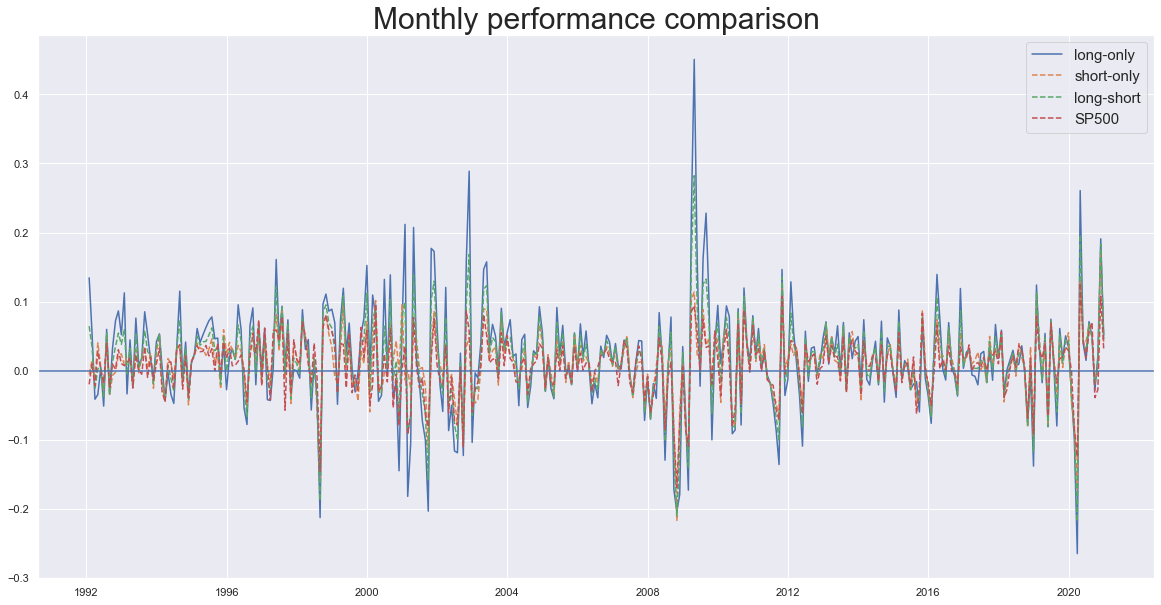

In [548]:
plt.figure(figsize=(20, 10))

plt.plot(port_m_ret['long_ret'], '-', label='long-only');
plt.plot(port_m_ret['short_ret'], '--', label='short-only');
plt.plot(port_m_ret['long_short_ret'], '--', label='long-short');
plt.plot(port_m_ret['s&p 500'], '--', label='SP500');

plt.axhline(0);
plt.title('Monthly performance comparison',fontsize=30)
plt.legend(fontsize=15);

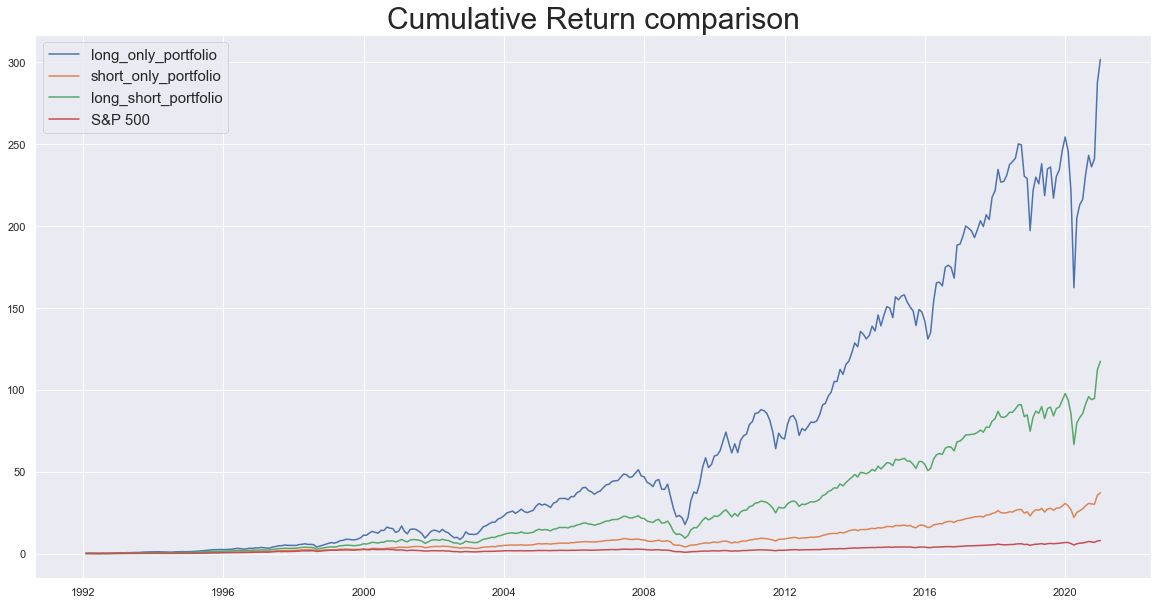

In [547]:
# get cumulative return 
port_ret_cum = (port_m_ret+1).cumprod()-1
# port_ret_cum = port_m_ret.cumsum()

plt.figure(figsize=(20, 10))
plt.plot(port_ret_cum)
plt.title('Cumulative Return comparison',fontsize=30)
plt.legend(['long_only_portfolio','short_only_portfolio','long_short_portfolio','S&P 500'],fontsize=15)

In [540]:
# annualized sharpe ratio
sharp_ratio = (port_m_ret.mean() / port_m_ret.std()) * np.sqrt(12)
sharp_ratio

long_ret          0.871129
short_ret         0.891503
long_short_ret    0.921811
s&p 500           0.596034
dtype: float64

### NN2

In [32]:
def NN2(learning_rate=0.001, k_reg = 10e-5): 
    '''
    two hidden layers with 32, 16, neurons
    '''
    model = Sequential()   
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu',kernel_regularizer=regularizers.l1(k_reg)))    
    model.add(Dense(1, activation='relu'))
        
    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=opt, metrics=['mse'])
        
    return model

In [ ]:
preddf_NN2 = pd.DataFrame() 
r2_OOS_NN2 = []

features = X_total.columns[:61]
rsquared_df_NN2 = pd.DataFrame(columns=['NN2'], index=features)
rsquared_df_NN2['NN2'] = np.zeros((len(rsquared_df_NN2),1)).tolist()

for start_date in tqdm(train_start_list):
    data = data_split(X_total, Y_total, permno_list, start_date, 14, 6, 26)
    train_x = data[0]
    train_y = data[1]
    valid_x = data[2]
    valid_y = data[3]
    test_x = data[4]
    test_y = data[5]
    test_permno = data[6]
    
    temp_preddf = pd.DataFrame() 
    temp_preddf['permno'] = test_permno
    temp_preddf['real_y'] = test_y.iloc[:,0]
    
    regr_NN2 = KerasRegressor(NN2)
    regr_NN2.fit(train_x, train_y, epochs=50,
                 validation_data=(valid_x, valid_y), 
                 callbacks=callback, 
                 batch_size=1000)
    
    predict_yNN2 = regr_NN2.predict(test_x)
    temp_preddf[start_date] = predict_yNN2
    
    r2_OOS_NN2.append(r2_oos(temp_preddf['real_y'],temp_preddf[start_date]))
    
    if start_date == train_start_list[0]:
        preddf_NN2 = preddf_NN2.append(temp_preddf)
    else:
        preddf_NN2 = pd.merge(preddf_NN2, temp_preddf, on=['date', 'permno'], how='outer')
    

    for feature in features:
        new_test_x = test_x.copy(deep=True)
        col = new_test_x.filter(like=feature, axis=1).columns  
        #if feature = 'adm', change all columns those contain adm to 0  
        new_test_x[col] = 0
                
        new_pred_NN2 = regr_NN2.predict(new_test_x)
        new_rsq_2 = r2_oos(temp_preddf['real_y'],new_pred_NN2)
        rsquared_df_NN2.loc[feature, 'NN2'].append(new_rsq_2)
        

  0%|                                                     | 0/4 [00:00<?, ?it/s]/var/folders/wt/38bxwst538g75np4smkby7mm0000gn/T/ipykernel_15798/3327628000.py:22: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  regr_NN2 = KerasRegressor(NN2)
2022-08-11 17:21:45.779707: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/50
145/145 [==============================] - 1s 5ms/step - loss: 0.0063 - mse: 0.5814 - val_loss: 0.0035 - val_mse: 0.2086
Epoch 2/50
145/145 [==============================] - 0s 3ms/step - loss: 0.0017 - mse: 0.1016 - val_loss: 3.6213e-04 - val_mse: 0.0145
Epoch 3/50
145/145 [==============================] - 0s 3ms/step - loss: 6.2638e-05 - mse: 0.0119 - val_loss: 6.4464e-06 - val_mse: 0.0132
Epoch 4/50
145/145 [==============================] - 0s 2ms/step - loss: 6.7952e-06 - mse: 0.0118 - val_loss: 6.6231e-06 - val_mse: 0.0132
Epoch 5/50
145/145 [==============================] - 0s 3ms/step - loss: 6.8061e-06 - mse: 0.0118 - val_loss: 6.9995e-06 - val_mse: 0.0132
Epoch 6/50
145/145 [==============================] - 0s 3ms/step - loss: 6.8112e-06 - mse: 0.0118 - val_loss: 6.9924e-06 - val_mse: 0.0132
Epoch 7/50
145/145 [==============================] - 0s 3ms/step - loss: 6.8076e-06 - mse: 0.0118 - val_loss: 6.7493e-06 - val_mse: 0.0132
Epoch 8/50
7439/7439 [==========

 25%|███████████                                 | 1/4 [16:04<48:14, 965.00s/it]/var/folders/wt/38bxwst538g75np4smkby7mm0000gn/T/ipykernel_15798/3327628000.py:22: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  regr_NN2 = KerasRegressor(NN2)


Epoch 1/50
146/146 [==============================] - 2s 13ms/step - loss: 0.0058 - mse: 0.0820 - val_loss: 0.0030 - val_mse: 0.0282
Epoch 2/50
146/146 [==============================] - 1s 3ms/step - loss: 0.0014 - mse: 0.0208 - val_loss: 2.8043e-04 - val_mse: 0.0133
Epoch 3/50
146/146 [==============================] - 0s 3ms/step - loss: 4.5931e-05 - mse: 0.0121 - val_loss: 6.6929e-06 - val_mse: 0.0131
Epoch 4/50
146/146 [==============================] - 0s 2ms/step - loss: 6.4203e-06 - mse: 0.0121 - val_loss: 6.5693e-06 - val_mse: 0.0131
Epoch 5/50
146/146 [==============================] - 0s 2ms/step - loss: 6.4228e-06 - mse: 0.0121 - val_loss: 6.2849e-06 - val_mse: 0.0131
Epoch 6/50
146/146 [==============================] - 0s 2ms/step - loss: 6.4148e-06 - mse: 0.0121 - val_loss: 6.9909e-06 - val_mse: 0.0131
Epoch 7/50
146/146 [==============================] - 0s 2ms/step - loss: 6.4283e-06 - mse: 0.0121 - val_loss: 6.4188e-06 - val_mse: 0.0131
Epoch 8/50
146/146 [===========

 50%|██████████████████████                      | 2/4 [32:13<32:13, 966.85s/it]/var/folders/wt/38bxwst538g75np4smkby7mm0000gn/T/ipykernel_15798/3327628000.py:22: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  regr_NN2 = KerasRegressor(NN2)


Epoch 1/50
146/146 [==============================] - 1s 5ms/step - loss: 0.0062 - mse: 0.3124 - val_loss: 0.0034 - val_mse: 0.2145
Epoch 2/50
146/146 [==============================] - 0s 3ms/step - loss: 0.0016 - mse: 0.0438 - val_loss: 2.9717e-04 - val_mse: 0.0148
Epoch 3/50
146/146 [==============================] - 0s 2ms/step - loss: 5.0587e-05 - mse: 0.0127 - val_loss: 6.3521e-06 - val_mse: 0.0116
Epoch 4/50
146/146 [==============================] - 0s 2ms/step - loss: 6.4471e-06 - mse: 0.0123 - val_loss: 6.3429e-06 - val_mse: 0.0116
Epoch 5/50
146/146 [==============================] - 0s 2ms/step - loss: 6.4490e-06 - mse: 0.0123 - val_loss: 6.3191e-06 - val_mse: 0.0116
Epoch 6/50
146/146 [==============================] - 0s 2ms/step - loss: 6.4539e-06 - mse: 0.0123 - val_loss: 6.4494e-06 - val_mse: 0.0116
Epoch 7/50
146/146 [==============================] - 0s 2ms/step - loss: 6.4404e-06 - mse: 0.0123 - val_loss: 6.6016e-06 - val_mse: 0.0116
Epoch 8/50
146/146 [============

In [ ]:
NN2_pred_result = preddf_NN2.copy(deep=True)
print(r2_OOS_NN2)
print(f'mean of r2_oo2 is: {np.mean(r2_OOS_NN2)}')

In [118]:
rsquared_df_adj = rsquared_df.copy(deep = True)


rsquared_df_adj['NN1'] = pd.DataFrame(rsquared_df_adj['NN1'].values.tolist()).drop(0,1).values.tolist()
rsquared_df_adj['NN1'] = rsquared_df_adj['NN1'].apply(np.mean)

rsquared_df_adj['NN2'] = pd.DataFrame(rsquared_df_adj['NN2'].values.tolist()).drop(0,1).values.tolist()
rsquared_df_adj['NN2'] = rsquared_df_adj['NN2'].apply(np.mean)
    
oos_feature = pd.DataFrame(columns=['NN1','NN2'], index=X_total.columns[:61])
oos_feature['NN1'] = np.mean(r2_OOS_NN1)
oos_feature['NN2'] = np.mean(r2_OOS_NN2)



rsquared_reduction = pd.DataFrame(columns=['NN1','NN2'], index=X_total.columns[:61])
rsquared_normalized = pd.DataFrame(columns=['NN1','NN2'], index=X_total.columns[:61])

for i in ['NN1','NN2']:
    rsquared_reduction[i] = np.abs(oos_feature.loc[:,i] - rsquared_df_adj.loc[:,i])
    rsquared_normalized[i] = rsquared_reduction.loc[:,i] / rsquared_reduction.loc[:,i].sum()

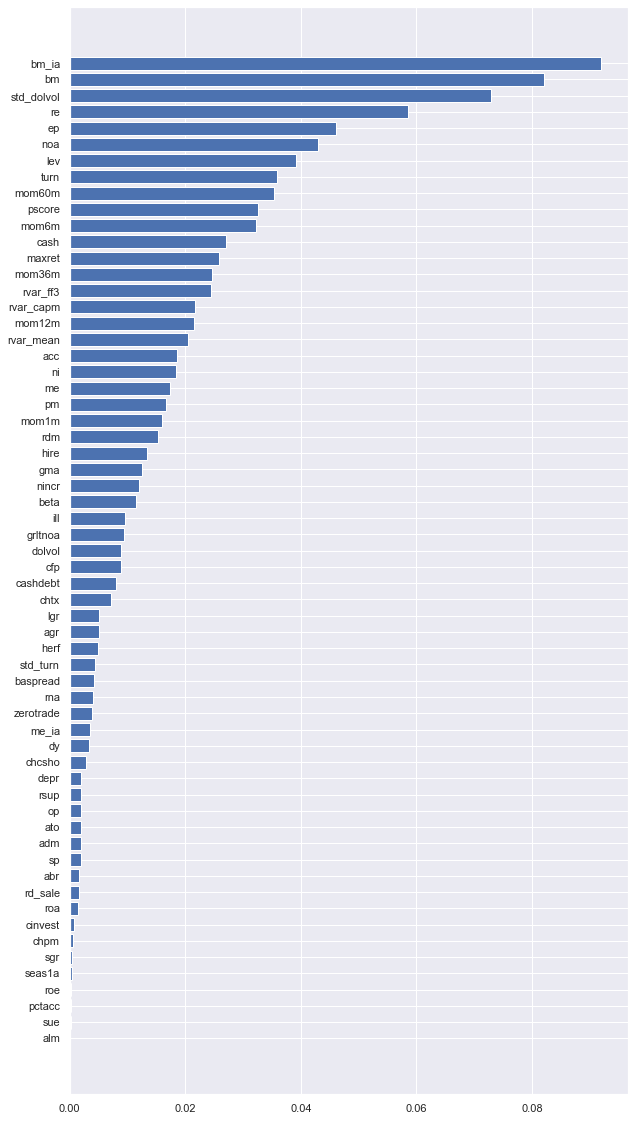

In [119]:
NN1_FI = pd.DataFrame(rsquared_normalized['NN1'].sort_values(ascending=True))

plt.figure(figsize=(10, 20))
plt.barh(NN1_FI.index, NN1_FI['NN1'])
plt.show()

In [ ]:
NN2_FI = pd.DataFrame(rsquared_normalized['NN2'].sort_values(ascending=True))

plt.figure(figsize=(10, 20))
plt.barh(NN2_FI.index, NN2_FI['NN2'])
plt.show()

### NN3

In [ ]:
def NN3(learning_rate=0.001, k_reg = 10e-5): 
    '''
    three hidden layers with 32, 16, 8 neurons
    '''
    model = Sequential()        
    model.add(Dense(32,activation='relu',kernel_regularizer=regularizers.l1(k_reg)))
    model.add(Dense(16, activation='relu'))       
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='relu'))
        
    opt = tf.keras.optimizers.Adam(learning_rate)
    model.compile(optimizer=opt, metrics=['mse'])
        
    return model

In [ ]:
preddf_NN3 = pd.DataFrame() 
r2_OOS_NN3 = []

rsquared_df['NN3'] = np.zeros((len(rsquared_df),1)).tolist()

for start_date in tqdm(train_start_list):
    data = data_split(X_total, Y_total, permno_list, start_date, 14, 6, 26)
    train_x = data[0]
    train_y = data[1]
    valid_x = data[2]
    valid_y = data[3]
    test_x = data[4]
    test_y = data[5]
    test_permno = data[6]
    
    temp_preddf = pd.DataFrame() 
    temp_preddf['permno'] = test_permno 
    temp_preddf['real_y'] = test_y.iloc[:,0]
    
    regr_NN3 = KerasRegressor(NN3)
    regr_NN3.fit(train_x, train_y, epochs=50,
                 validation_data=(valid_x, valid_y), 
                 callbacks=callback, 
                 batch_size=1000)
    
    predict_yNN3 = regr_NN3.predict(test_x)
    temp_preddf['NN3_y'] = predict_yNN3
    
    r2_OOS_NN3.append(r2_oos(temp_preddf['real_y'],temp_preddf['NN3_y']))
    
    preddf_NN3.append(temp_preddf)
    

    for feature in features:
        new_test_x = test_x.copy(deep=True)
        col = new_test_x.filter(like=feature, axis=1).columns  
        #if feature = 'adm', change all columns those contain adm to 0  
        new_test_x[col] = 0
                
        new_pred_NN3 = regr_NN3.predict(new_test_x)
        new_rsq_3 = r2_oos(temp_preddf['real_y'],new_pred_NN3)
        rsquared_df.loc[feature, 'NN3'].append(new_rsq_3)

In [ ]:
NN3_pred_result = preddf_NN3.copy(deep=True)

print(r2_OOS_NN3)
print(f'mean of r2_oo2 is: {np.mean(r2_OOS_NN3)}')

### NN4

In [ ]:
def NN4(learning_rate=0.001, k_reg = 10e-5): 
    '''
    four hidden layers with 32, 16, 8,4 neurons
    '''
    model = Sequential()        
    model.add(Dense(32,activation='relu',kernel_regularizer=regularizers.l1(k_reg)))
    model.add(Dense(16, activation='relu'))  
    model.add(Dense(8, activation='relu'))
    model.add(Dense(4, activation='relu'))
    model.add(Dense(1, activation='relu'))
        
    opt = tf.keras.optimizers.Adam(learning_rate)
    model.compile(optimizer=opt, metrics=['mse'])
        
    return model

In [ ]:
preddf_NN4 = pd.DataFrame() 
r2_OOS_NN4 = []

rsquared_df['NN4'] = np.zeros((len(rsquared_df),1)).tolist()

for start_date in tqdm(train_start_list):
    data = data_split(X_total, Y_total, permno_list, start_date, 14, 6, 26)
    train_x = data[0]
    train_y = data[1]
    valid_x = data[2]
    valid_y = data[3]
    test_x = data[4]
    test_y = data[5]
    test_permno = data[6]
    
    temp_preddf = pd.DataFrame() 
    temp_preddf['permno'] = test_permno
    temp_preddf['real_y'] = test_y.iloc[:,0]
    
    regr_NN4 = KerasRegressor(NN4)
    regr_NN4.fit(train_x, train_y, epochs=50,
                 validation_data=(valid_x, valid_y), 
                 callbacks=callback, 
                 batch_size=1000)
    
    predict_yNN4 = regr_NN4.predict(test_x)
    temp_preddf['NN4_y'] = predict_yNN4
    
    r2_OOS_NN4.append(r2_oos(temp_preddf['real_y'],temp_preddf['NN4_y']))
    
    preddf_NN4.append(temp_preddf)
    

    for feature in features:
        new_test_x = test_x.copy(deep=True)
        col = new_test_x.filter(like=feature, axis=1).columns  
        #if feature = 'adm', change all columns those contain adm to 0  
        new_test_x[col] = 0
                
        new_pred_NN4 = regr_NN4.predict(new_test_x)
        new_rsq_4 = r2_oos(temp_preddf['real_y'],new_pred_NN4)
        rsquared_df.loc[feature, 'NN4'].append(new_rsq_4)

In [ ]:
NN4_pred_result = preddf_NN4.copy(deep=True)

print(r2_OOS_NN4)
print(f'mean of r2_oo2 is: {np.mean(r2_OOS_NN4)}')

### NN5

In [ ]:
def NN5(learning_rate=0.001, k_reg = 10e-5):   
    '''
    five hidden layers with 32, 16, 8, 4, 2 neurons
    '''
    model = Sequential()        
    model.add(Dense(32, activation='relu',kernel_regularizer=regularizers.l1(k_reg)))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(4, activation='relu'))
    model.add(Dense(2, activation='relu'))
    model.add(Dense(1, activation='relu'))
        
    opt = tf.keras.optimizers.Adam(learning_rate)
    model.compile(optimizer=opt, metrics=['mse'])
                
    return model

In [ ]:
preddf_NN5 = pd.DataFrame() 
r2_OOS_NN5 = []

rsquared_df['NN5'] = np.zeros((len(rsquared_df),1)).tolist()

for start_date in tqdm(train_start_list):
    data = data_split(X_total, Y_total, permno_list, start_date, 14, 6, 26)
    train_x = data[0]
    train_y = data[1]
    valid_x = data[2]
    valid_y = data[3]
    test_x = data[4]
    test_y = data[5]
    test_permno = data[6]
    
    temp_preddf = pd.DataFrame() 
    temp_preddf['permno'] = test_permno
    temp_preddf['real_y'] = test_y.iloc[:,0]
    
    regr_NN5 = KerasRegressor(NN5)
    regr_NN5.fit(train_x, train_y, epochs=50,
                 validation_data=(valid_x, valid_y), 
                 callbacks=callback, 
                 batch_size=1000)
    
    predict_yNN5 = regr_NN5.predict(test_x)
    temp_preddf['NN5_y'] = predict_yNN5
    
    r2_OOS_NN5.append(r2_oos(temp_preddf['real_y'],temp_preddf['NN5_y']))
    
    preddf_NN5.append(temp_preddf)
    

    for feature in features:
        new_test_x = test_x.copy(deep=True)
        col = new_test_x.filter(like=feature, axis=1).columns  
        #if feature = 'adm', change all columns those contain adm to 0  
        new_test_x[col] = 0
                
        new_pred_NN5 = regr_NN5.predict(new_test_x)
        new_rsq_5 = r2_oos(temp_preddf['real_y'],new_pred_NN5)
        rsquared_df.loc[feature, 'NN5'].append(new_rsq_5)

In [ ]:
NN5_pred_result = preddf_NN5.copy(deep=True)

print(r2_OOS_NN5)
print(f'mean of r2_oo2 is: {np.mean(r2_OOS_NN5)}')

## Prediction & OOS R2 & Feather importance

In [ ]:
predd_result

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(predd_result)
plt.legend(['real_y','NN1_y','NN2_y','NN3_y','NN4_y','NN5_y'])

In [83]:
# calculate r2oos each rolling and make average
r2_oos_NN = pd.DataFrame({'model':['NN1','NN2','NN3','NN4','NN5'],
                          'r2_oos':[np.mean(r2_OOS_NN1),np.mean(r2_OOS_NN2),np.mean(r2_OOS_NN3),np.mean(r2_OOS_NN4),np.mean(r2_OOS_NN5)]})
r2_oos_NN

,model,r2_oos
0,NN1,0.001163
1,NN2,0.000002
2,NN3,0.001014
3,NN4,0.000185
4,NN5,0.000499


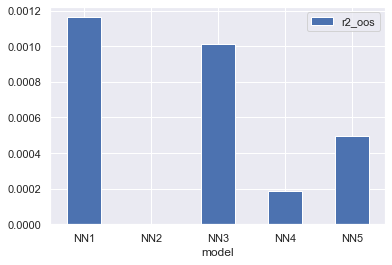

In [84]:
# plot r2_oos

ax = r2_oos_NN.plot.bar(x='model', y='r2_oos', rot=0)

In [91]:
#调整rsquared_df -- calculate average of rsquared, rsquared reduction, rsquared normalized
rsquared_df_adj = rsquared_df.copy(Deep = True)

for i in rsquared_df_adj.columns:
    rsquared_df_adj[i] = pd.DataFrame(rsquared_df_adj[i].values.tolist()).drop(0,1).values.tolist()
    rsquared_df_adj[i] = rsquared_df_adj[i].apply(np.mean)
    
oos_feature = pd.DataFrame(columns=['NN1','NN2','NN3','NN4','NN5'], index=X_total.columns[:61])

for i in range(len(rsquared_df_adj.columns)):
    oos_feature.iloc[:,i] = r2_oos_NN['r2_oos'][i]

rsquared_reduction = pd.DataFrame(columns=['NN1','NN2','NN3','NN4','NN5'], index=X_total.columns[:61])
rsquared_normalized = pd.DataFrame(columns=['NN1','NN2','NN3','NN4','NN5'], index=X_total.columns[:61])

for i in ['NN1','NN2','NN3','NN4','NN5']:
    rsquared_reduction[i] = np.abs(oos_feature.loc[:,i] - rsquared_df_adj.loc[:,i])
    rsquared_normalized[i] = rsquared_reduction.loc[:,i] / rsquared_reduction.loc[:,i].sum()

C:\Users\haosh\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\haosh\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\haosh\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\haosh\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\haosh\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


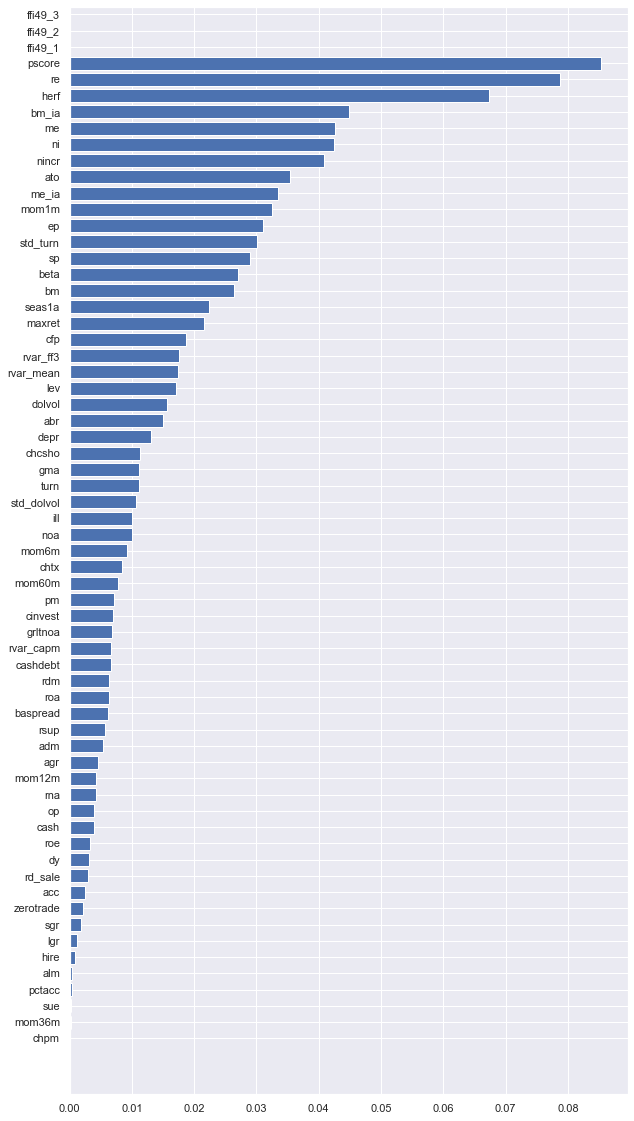

In [87]:
# plot features importance
NN1_FI = pd.DataFrame(rsquared_normalized['NN1'].sort_values(ascending=True))

plt.figure(figsize=(10, 20))
plt.barh(NN1_FI.index, NN1_FI['NN1'])
plt.show()

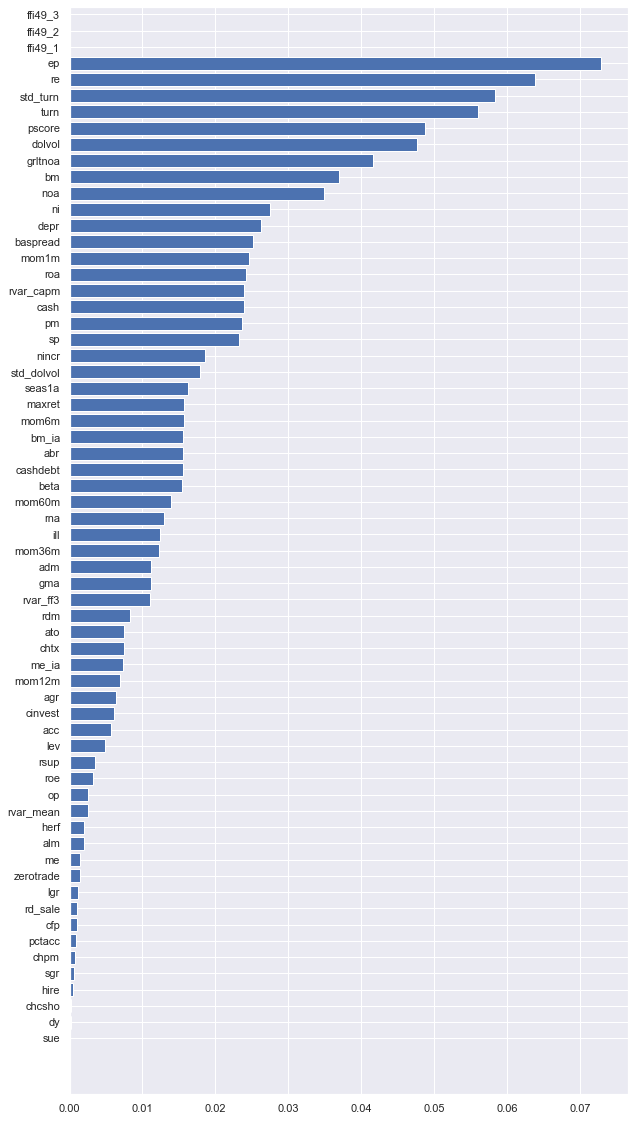

In [89]:
NN2_FI = pd.DataFrame(rsquared_normalized['NN2'].sort_values(ascending=True))

plt.figure(figsize=(10, 20))
plt.barh(NN2_FI.index, NN2_FI['NN2'])
plt.show()

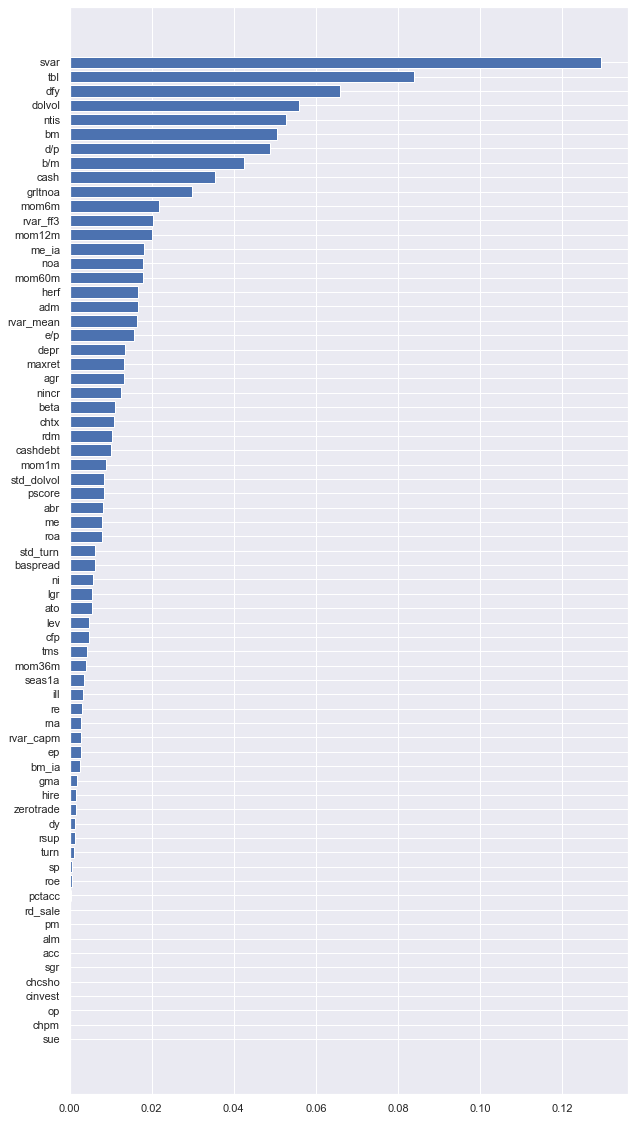

In [ ]:
NN3_FI = pd.DataFrame(rsquared_normalized['NN3'].sort_values(ascending=True))

plt.figure(figsize=(10, 20))
plt.barh(NN3_FI.index, NN3_FI['NN3'])
plt.show()

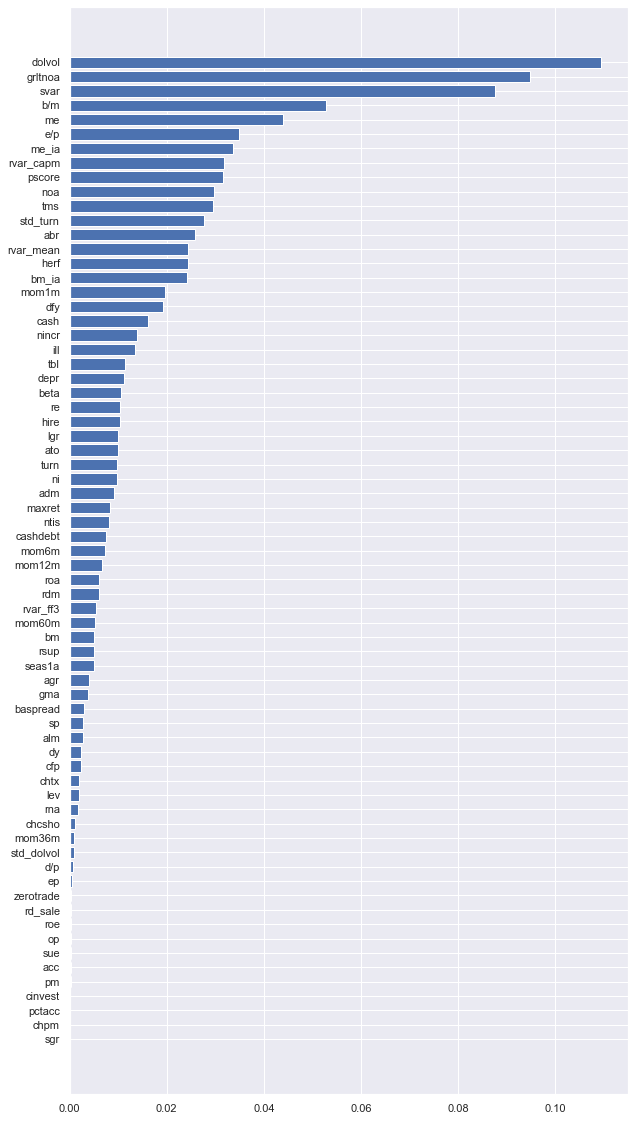

In [ ]:
NN4_FI = pd.DataFrame(rsquared_normalized['NN4'].sort_values(ascending=True))

plt.figure(figsize=(10, 20))
plt.barh(NN4_FI.index, NN4_FI['NN4'])
plt.show()

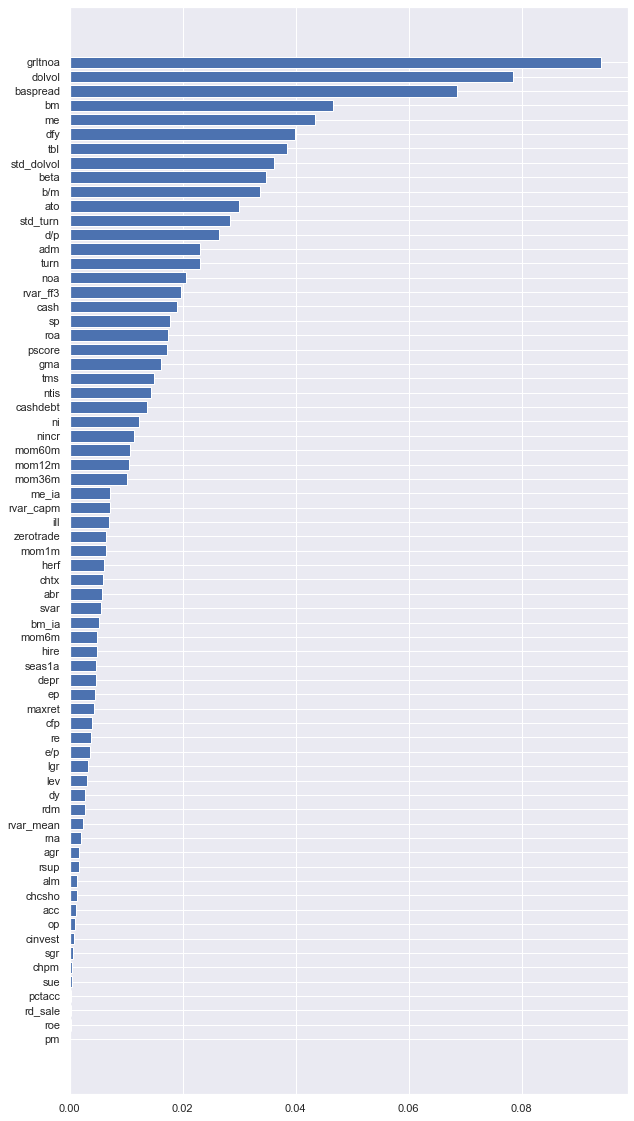

In [ ]:
NN5_FI = pd.DataFrame(rsquared_normalized['NN5'].sort_values(ascending=True))

plt.figure(figsize=(10, 20))
plt.barh(NN5_FI.index, NN5_FI['NN5'])
plt.show()

## parameter

In [123]:
data = rolling1
train_x = data[0]
train_y = data[1]
valid_x = data[2]
valid_y = data[3]
test_x = data[4]
test_y = data[5]
    
temp_preddf = pd.DataFrame() 
temp_preddf['real_y'] = test_y.iloc[:,0]
    
regr_NN1 = KerasRegressor(NN1)
# regr_NN1.fit(train_x, train_y, epochs=100,
#                  validation_data=(valid_x, valid_y), 
#                  callbacks=callback, 
#                  batch_size=10000)
    
# predict_yNN1 = regr_NN1.predict(test_x)
# temp_preddf['NN1_y'] = predict_yNN1

C:\Users\haosh\AppData\Local\Temp\ipykernel_12676\1672158916.py:12: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  regr_NN1 = KerasRegressor(NN1)


In [126]:
def parm_tuning(train_x, train_y, valid_x, valid_y, regr_NN1):
    
    params ={
        'epochs': np.arange(10, 100,10),
        'batch_size': np.arange(500, 10000,500),
        'learning_rate':uniform(loc=0.001, scale = 0.05),
        'k_reg': [10e-5,10e-3]
    }
    
    r2oos_score = make_scorer(r2_oos, greater_is_better=True)
    scoring_dict = {'r2_oos':r2oos_score, 'mse':'neg_mean_squared_error'}

    grid = RandomizedSearchCV(model, params, n_iter=15, cv=3, verbose=2, scoring= scoring_dict, refit ='r2_oos')

    grid.fit(train_x, train_y,
             validation_data=(valid_x, valid_y),
            callbacks=callback)
    
    return grid

In [ ]:
NN1_search_cv= (train_x, train_y, valid_x, valid_y, regr_NN1)

# print(NN1_search_cv.best_params_)
regr_NN1_mod = NN1_search_cv.best_estimator_.model
regr_NN1_mod.fit(train_x, train_y,
                  validation_data=(valid_x, valid_y),
                  callbacks=callback)

preddf_NN1['NN1_y_best'] = regr_NN1_mod.predict(test_x)
r2_oos(preddf_NN1['NN1_y_best'],preddf_NN1['real_y'])

## 草稿

In [ ]:
a = pd.date_range('19720101','19750101',freq='AS-JAN')
a

DatetimeIndex(['1972-01-01', '1973-01-01', '1974-01-01', '1975-01-01'], dtype='datetime64[ns]', freq='AS-JAN')

In [ ]:
for start_date in tqdm(a):
    start_date = a[3] # test
    end_date = start_date + 32 * YearEnd()
    valid_date = end_date + 7 * YearEnd() 
    test_date = valid_date + 7 * YearEnd()
    
#     start_date = start_date.strftime('%Y%m%d') # 转化成字符型
#     end_date = end_date.strftime('%Y%m%d')
#     valid_date = valid_date.strftime('%Y%m%d')
    

100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 4490.69it/s]


In [ ]:
start_date

Timestamp('1975-01-01 00:00:00', freq='AS-JAN')

In [ ]:
end_date

Timestamp('2006-12-31 00:00:00', freq='AS-JAN')

In [ ]:
valid_date

Timestamp('2013-12-31 00:00:00', freq='AS-JAN')

In [ ]:
test_date

Timestamp('2020-12-31 00:00:00', freq='AS-JAN')

In [ ]:
train_x = X_total.loc[start_date.strftime('%Y%m%d'):end_date.strftime('%Y%m%d')]

/var/folders/wt/38bxwst538g75np4smkby7mm0000gn/T/ipykernel_7121/3218650665.py:1: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  train_x = X_total.loc[start_date.strftime('%Y%m%d'):end_date.strftime('%Y%m%d')]


In [ ]:
train_x

,sic,adm,bm_ia,herf,hire,...,svar,d/p,e/p,dfy,tms
date,,,,,,,,,,,
1972-01-31,-0.369620,-0.266273,0.060930,1.331469,-0.018029,...,-0.373084,-0.252113,0.126767,-0.107256,0.42651
1972-01-31,-0.255454,0.014889,-0.276326,-0.500789,-0.010624,...,-0.373084,-0.252113,0.126767,-0.107256,0.42651
1972-01-31,0.349179,0.014889,0.113205,2.258603,-0.021854,...,-0.373084,-0.252113,0.126767,-0.107256,0.42651
1972-01-31,0.056561,-0.040853,-0.850659,-0.833250,-0.016621,...,-0.373084,-0.252113,0.126767,-0.107256,0.42651
1972-01-31,-0.385692,0.014889,1.557838,-0.219789,-0.013646,...,-0.373084,-0.252113,0.126767,-0.107256,0.42651
...,...,...,...,...,...,...,...,...,...,...,...
1999-12-31,-0.385692,0.026540,-1.461352,-0.025041,-0.013646,...,-0.248607,1.948820,1.222879,-0.999526,-0.43688
1999-12-31,-0.872280,-0.246817,-0.196741,-0.718728,-0.013646,...,-0.248607,1.948820,1.222879,-0.999526,-0.43688
1999-12-31,1.640466,-0.253714,-0.062528,0.418700,-0.013646,...,-0.248607,1.948820,1.222879,-0.999526,-0.43688


In [376]:
a = pd.DataFrame(data = [2,5,6], columns=['NN1'], index = [1,2,3])
b = pd.DataFrame(data = [5,6,0], columns=['NN2'], index = [2,3,4])


In [377]:
c = pd.concat([a, b], axis=1)
c

,NN1,NN2
1,2.0,NaN
2,5.0,5.0
3,6.0,6.0
4,NaN,0.0


In [378]:
c['merge'] = c[['NN1','NN2']].max(axis=1)
c

,NN1,NN2,merge
1,2.0,NaN,2.0
2,5.0,5.0,5.0
3,6.0,6.0,6.0
4,NaN,0.0,0.0


In [380]:
c.loc[2,'NN2']

5.0

In [ ]:
rsquared = pd.DataFrame(columns=['NN1','NN2','NN3','NN4','NN5'], index=features_list)

In [ ]:
rsquared

,NN1,NN2,NN3,NN4,NN5
sic,NaN,NaN,NaN,NaN,NaN
adm,NaN,NaN,NaN,NaN,NaN
bm_ia,NaN,NaN,NaN,NaN,NaN
herf,NaN,NaN,NaN,NaN,NaN
hire,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
shrcd_10.0,NaN,NaN,NaN,NaN,NaN
shrcd_11.0,NaN,NaN,NaN,NaN,NaN
exchcd_1.0,NaN,NaN,NaN,NaN,NaN
exchcd_2.0,NaN,NaN,NaN,NaN,NaN


In [ ]:
len(np.zeros((123,1) * 5) * 5)

In [ ]:
len(rsquared)

123

In [ ]:
rsquared['NN1'] = np.zeros((len(rsquared),1)).tolist()

In [ ]:
rsquared.loc['sic','NN1']

In [ ]:
rsquared.loc['sic','NN1'].append(1)

In [ ]:
np.mean(rsquared.loc['sic','NN1'][1:])

1.0

In [ ]:
type(rsquared.loc['sic','NN1'])

str

In [ ]:
a = pd.DataFrame(columns=[1,2,3,4], index = [1,2,3,4])

In [ ]:
a.replace(np.NaN, '[1]', inplace=True)

In [ ]:
a

,1,2,3,4
1,1,1,1,1
2,1,1,1,1
3,1,1,1,1
4,1,1,1,1


In [ ]:
np.zeros(1).tolist()

[0.0]

In [ ]:
a = pd.DataFrame()

In [ ]:
a['NN1'] = [[0],[0],[0]]
a['NN2'] = [[0],[0],[0]]

In [ ]:
a

,NN1,NN2
0,"[0, 3, 3, 3, 3]","[0, 3, 3, 3, 3]"
1,"[0, 3, 3, 3, 3]","[0, 3, 3, 3, 3]"
2,"[0, 3, 3, 3, 3]","[0, 3, 3, 3, 3]"


In [ ]:
a.iloc[::2]

,NN1,NN2
0,"[0, 3, 3, 3, 3]","[0, 3, 3, 3, 3]"
2,"[0, 3, 3, 3, 3]","[0, 3, 3, 3, 3]"


In [ ]:
a.loc[0, 'NN1'].append(3)
a.loc[1, 'NN1'].append(3)
a.loc[2, 'NN1'].append(3)
a.loc[0, 'NN2'].append(3)
a.loc[1, 'NN2'].append(3)
a.loc[2, 'NN2'].append(3)

In [ ]:
x = a.copy()

In [ ]:
x

,NN1,NN2
0,"[0, 1, 2, 3]","[0, 1, 2, 3]"
1,"[0, 1, 2, 3]","[0, 1, 2, 3]"
2,"[0, 1, 2, 3]","[0, 1, 2, 3]"


In [ ]:
x['nn1'] = pd.DataFrame(x['NN1'].values.tolist()).drop(0,1).values.tolist()

/var/folders/wt/38bxwst538g75np4smkby7mm0000gn/T/ipykernel_7121/2815039839.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x['nn1'] = pd.DataFrame(x['NN1'].values.tolist()).drop(0,1).values.tolist()


In [ ]:
x['nn1']= x['nn1'].apply(np.mean)

In [ ]:
x

,NN1,NN2,nn1
0,"[0, 1, 2, 3]","[0, 1, 2, 3]",2.0
1,"[0, 1, 2, 3]","[0, 1, 2, 3]",2.0
2,"[0, 1, 2, 3]","[0, 1, 2, 3]",2.0


In [ ]:
a['NN1']

0    [0, 1, 1, 1, 1]
1    [0, 1, 1, 1, 1]
2    [0, 1, 1, 1, 1]
Name: NN1, dtype: object

In [ ]:
a['NN2'].apply(np.mean)

1    1.5
2    2.0
3    2.5
Name: NN2, dtype: float64

In [ ]:
def model():
    a = 1
    b = 2
    c = 3
    return a, b, c

AttributeError: 'tuple' object has no attribute 'b'

In [ ]:
features_list

['adm',
 'bm_ia',
 'herf',
 'hire',
 'me_ia',
 'baspread',
 'beta',
 'ill',
 'maxret',
 'mom12m',
 'mom1m',
 'mom36m',
 'mom60m',
 'mom6m',
 're',
 'rvar_capm',
 'rvar_ff3',
 'rvar_mean',
 'seas1a',
 'std_dolvol',
 'std_turn',
 'zerotrade',
 'me',
 'dy',
 'turn',
 'dolvol',
 'abr',
 'sue',
 'cinvest',
 'nincr',
 'pscore',
 'acc',
 'bm',
 'agr',
 'alm',
 'ato',
 'cash',
 'cashdebt',
 'cfp',
 'chcsho',
 'chpm',
 'chtx',
 'depr',
 'ep',
 'gma',
 'grltnoa',
 'lev',
 'lgr',
 'ni',
 'noa',
 'op',
 'pctacc',
 'pm',
 'rd_sale',
 'rdm',
 'rna',
 'roa',
 'roe',
 'rsup',
 'sgr',
 'sp',
 'b/m',
 'tbl',
 'ntis',
 'svar',
 'd/p',
 'e/p',
 'dfy',
 'tms',
 'ffi49_1',
 'ffi49_2',
 'ffi49_3',
 'ffi49_4',
 'ffi49_5',
 'ffi49_6',
 'ffi49_7',
 'ffi49_8',
 'ffi49_9',
 'ffi49_10',
 'ffi49_11',
 'ffi49_12',
 'ffi49_13',
 'ffi49_14',
 'ffi49_15',
 'ffi49_16',
 'ffi49_17',
 'ffi49_18',
 'ffi49_19',
 'ffi49_21',
 'ffi49_22',
 'ffi49_23',
 'ffi49_24',
 'ffi49_25',
 'ffi49_26',
 'ffi49_27',
 'ffi49_28',
 'ffi49_29

https://github.com/AdamTseng1208/Empirical-Asset-Pricing-with-ML/blob/master/EmpiricalAssetPricing_MachineLearning.py

In [54]:
a = pd.DataFrame({'adm': [1,2,3],
                 'tms':[4,5,6],
                 'bm':[7,8,9],
                 'adm+tms':[3,4,5]})

In [55]:
a

,adm,tms,bm,adm+tms
0,1,4,7,3
1,2,5,8,4
2,3,6,9,5


In [57]:
a['adm'] = 0
a

,adm,tms,bm,adm+tms
0,0,4,7,3
1,0,5,8,4
2,0,6,9,5


In [ ]:
col = a.filter(like=i, axis=1).columns

In [ ]:
a[col] = 0  

In [ ]:
a

,adm,tms,bm,adm+tms
0,0,4,7,0
1,0,5,8,0
2,0,6,9,0
